<a href="https://colab.research.google.com/github/shivammehta007/NLPResearch/blob/master/Tutorials/Generative%20Models/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Writing A Variational Encoder in PyTorch
First Lets Import all the libraries needed

In [1]:
! pip install -U tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.41.1)


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Loading the Data, Lets use our favourite dataset MNIST

In [0]:
transformer = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST(root='.data/', train=True, download=True, transform=transformer)
test_data = datasets.MNIST(root='.data/',train=False, download=True, transform=transformer)

Initializing Data Set Iterators for easy and batched access

In [0]:
BATCH_SIZE = 64

train_iterator = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_data, batch_size=BATCH_SIZE)


In [5]:
tmpx, tmpy = iter(train_iterator).next()
tmpx.shape, tmpy

(torch.Size([64, 1, 28, 28]),
 tensor([0, 6, 0, 2, 1, 7, 7, 3, 9, 5, 4, 7, 3, 7, 7, 9, 2, 3, 5, 1, 0, 6, 1, 8,
         6, 3, 3, 8, 0, 2, 8, 5, 1, 1, 0, 6, 4, 2, 8, 2, 3, 7, 9, 9, 4, 8, 5, 6,
         0, 4, 9, 3, 6, 7, 0, 1, 5, 4, 4, 5, 4, 6, 1, 1]))

Now Lets Define the HyperParameters of our VAE 
Since, VAE is nothing but a combination of Autoencoders, lets define how our architecture will look like

* size of each input
* hidden dimension
* latent vector dimension
* learning rate      

In [0]:
INPUT_DIM = 28 * 28
HIDDEN_DIM = 256
LATENT_DIM = 20
lr = 1e-3
CHANNELS = 32
DROPOUT = 0.7

In VAE we have one Encoder $ q_\phi (z | x) $ , Lets first define that

Quick Note: Size of next convolutional layer : 
$$ OW = \dfrac{W - f_ + 2P}{S} + 1 $$
where W is the width, f is the filter, p is the padding and S is the Stride

In [0]:
class Encoder(nn.Module):
    '''
        This is the Encoder of VAE
    '''
    def __init__(self, channels, input_dim, hidden_dim, latent_dim, dropout):
        super(Encoder, self).__init__()
        # Image size : (1, 28, 28)
        self.conv1 = nn.Conv2d(1, channels, 4, 2, 1)
        # 32, 14, 14
        self.conv2 = nn.Conv2d(channels, channels * 4, 4, 2, 1)
        # 128, 7, 7
        self.linear = nn.Linear(128 * 7* 7, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 128*7*7)
        x = self.dropout(F.relu(self.linear(x)))
        
        mu_z = self.mu(x)
        var_z = self.var(x)

        return mu_z, var_z


Now, Lets Code Decoder $ p_\theta (x | z) $  which will take latent as input and give generated image as output 

De Conv Formula will just be opposite
$$ \left(OW - 1 \right) S + F - 2P = W $$

In [0]:
class Decoder(nn.Module):
    '''
        This is the Decoder part of VAE
    '''
    def __init__(self, channel, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.upsampling_linear = nn.Linear(latent_dim, 128 * 7 * 7)     
        # 128, 7, 7
        self.upconv = nn.ConvTranspose2d(channel * 4, channel, 4, 2, 1) 
        # 32, 14, 14 
        self.upconv2 = nn.ConvTranspose2d(channel, 1, 4, 2, 1)
        # 1, 28, 28
        self.out = nn.Linear(1 * 28 * 28, output_dim)

    def forward(self, x):
        x = F.relu(self.upsampling_linear(x))
        x = x.view(-1, 128, 7, 7)
        x = F.relu(self.upconv(x))
        x = F.relu(self.upconv2(x))
        x = x.view(-1, 1 * 28 * 28)
        output = torch.sigmoid(self.out(x))
    
        return output

Now we have both our encoder and decoder, Lets write the final architecture of our VAE


In [0]:
class VAE(nn.Module):
    def __init__(self, enc, dec):
        super(VAE, self).__init__()
        self.encoder = enc
        self.decoder = dec
    
    def reparameterization_sampling(self, mu, var):
        std = torch.exp(var / 2)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu_z, var_z = self.encoder(x)
        x_sample = self.reparameterization_sampling(mu_z, var_z)
        prediction = self.decoder(x_sample)
        return prediction, mu_z, var_z
        

Lets, Initialize the Model

In [0]:
encoder = Encoder(CHANNELS, INPUT_DIM, HIDDEN_DIM, LATENT_DIM, DROPOUT)
decoder = Decoder(CHANNELS, LATENT_DIM, HIDDEN_DIM, INPUT_DIM)

model = VAE(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
print('{:,}'.format(sum([p.numel() for p in model.parameters() if p.requires_grad])))

2,495,609


So we know that the LOSS of VAE is the Reconstruction loss and KL Divergence
So final loss function will give be = RL + KL


In [0]:
def reconstruction_loss(sampled_input, original_input):
    return F.binary_cross_entropy(sampled_input, original_input, reduction='sum')

def kl_divergence(mu_z, var_z):
    return 0.5 * torch.sum(torch.exp(var_z) + mu_z**2 - 1.0 - var_z)

Lets now Train the Model 

In [0]:
def train(model, iterator, optimizer):
    model.train()

    train_loss = 0

    for i, (x, _) in enumerate(iterator):
        # Update the size of array
        x = x.to(device)

        # Forward Prop
        x_sample, mu_z, var_z = model(x)
        x_sample = x_sample.view(-1, 1, 28, 28)
        # Calculating Loss
        loss = reconstruction_loss(x_sample, x) + kl_divergence(mu_z, var_z)

        # Backpropagate
        loss.backward()

        # Update Train_loss
        train_loss += loss.item()

        optimizer.step()
    
    return train_loss



In [0]:
def test(model, iterator, optimizer):
    model.eval()

    test_loss = 0

    with torch.no_grad():
        for i, (x, _) in enumerate(iterator):
            x = x.to(device)

            x_sample, mu_z, var_z = model(x)
            x_sample = x_sample.view(-1, 1, 28, 28)

            loss = reconstruction_loss(x_sample, x) + kl_divergence(mu_z, var_z)

            test_loss += loss.item()
    
    return test_loss

        

In [0]:
N_EPOCHS = 5

Finally Training the Model with iterators and dataset

Epoch :01, Train_loss : 275.1119 Test_loss: 243.6090


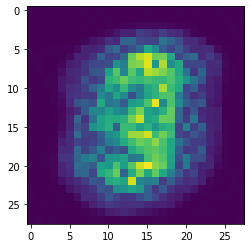

Epoch :02, Train_loss : 256.4329 Test_loss: 235.3201


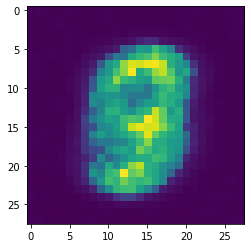

Epoch :03, Train_loss : 227.9344 Test_loss: 218.8517


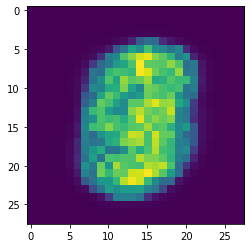

Epoch :04, Train_loss : 218.6350 Test_loss: 220.1565


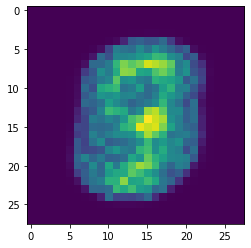

Epoch :05, Train_loss : 221.1676 Test_loss: 218.9861


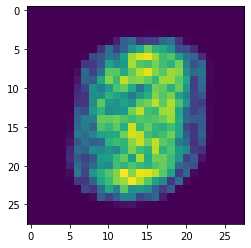

In [16]:
 for epoch in tqdm(range(N_EPOCHS)):

        train_loss = train(model, train_iterator, optimizer)
        test_loss = test(model, test_iterator, optimizer)

        train_loss /= len(train_data)
        test_loss /= len(test_data)

        print('Epoch :{:02d}, Train_loss : {:.4f} Test_loss: {:.4f}'.format(epoch + 1, train_loss, test_loss))
        model.eval()
        recon_img, _, _ = model(tmpx[:1].to(device))
        img = recon_img.view(28, 28).detach().cpu().numpy()
        
        plt.imshow(img)
        plt.show()

torch.Size([1, 20])
torch.Size([28, 28])


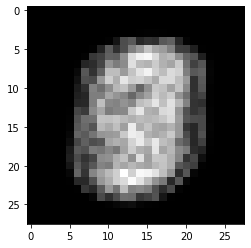

In [19]:
z = torch.randn(1, LATENT_DIM).to(device)
# run only the decoder
reconstructed_img = model.decoder(z)
img = reconstructed_img.view(28, 28).data

print(z.shape)
print(img.shape)
plt.imshow(img.cpu(), cmap='gray')
plt.show()